In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_ipsl_ = np.genfromtxt('pr_Amon_IPSL-CM5A-LR_past1000_r1i1p1_0850_1850_goswami_india_tseries.csv', delimiter=",", dtype=float)[0:12000]*86400
data_giss_ = np.genfromtxt('pr_Amon_GISS-E2-R_past1000_r1i1p128_0850_1850_goswami_india_tseries.csv', delimiter=",", dtype=float)[0:12000]*86400 
data_mpi_ = np.genfromtxt('pr_Amon_MPI-ESM-P_past1000_r1i1p1_085001-184912_goswami_india_tseries.csv', delimiter=",", dtype=float)[0:12000]*86400 
yy = np.arange(850,1850,1/12)

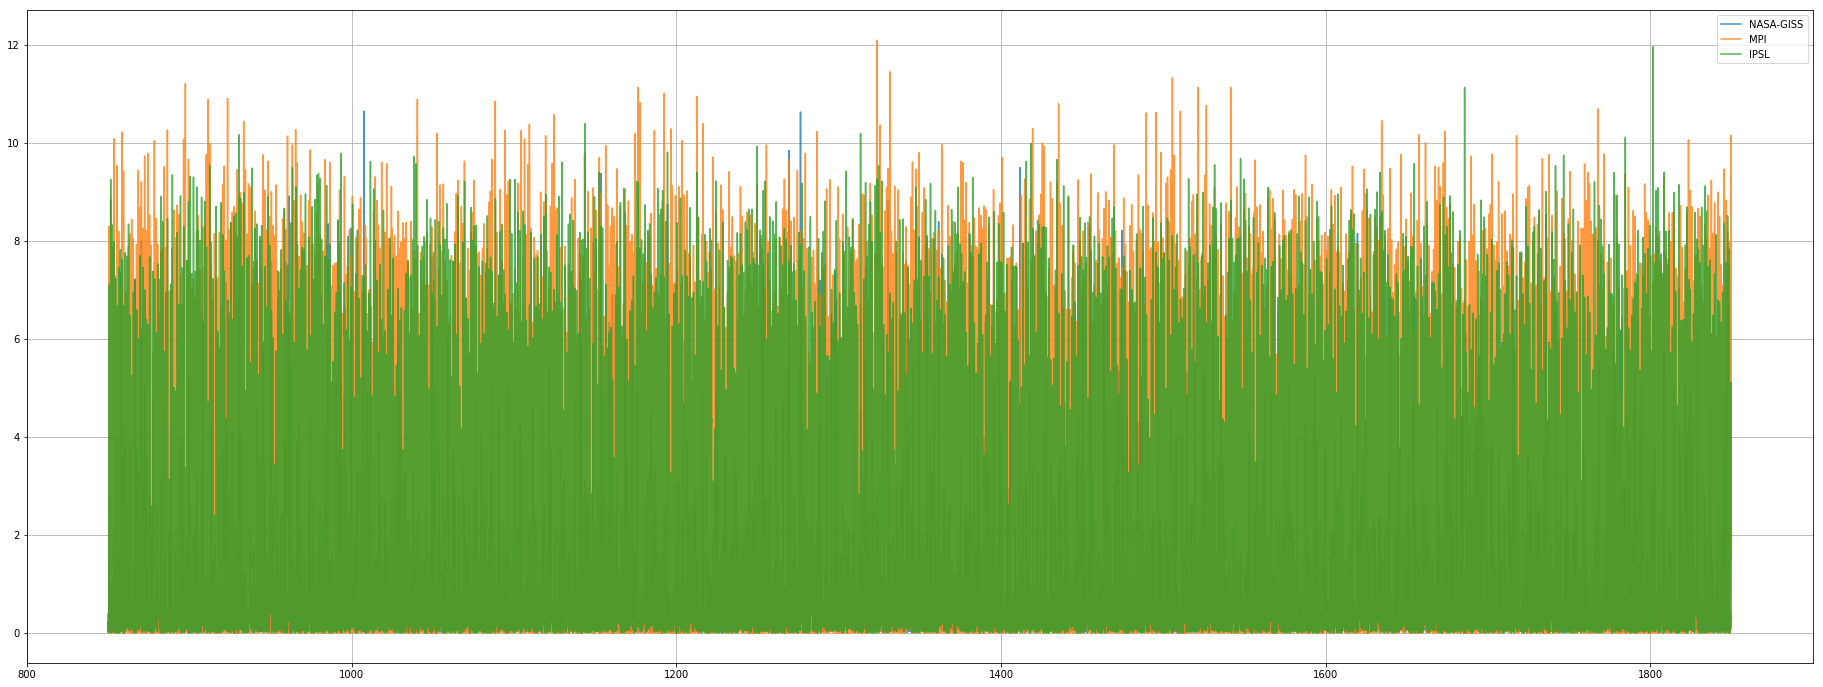

In [3]:
plt.figure(figsize=(32,12))
plt.plot(yy, data_giss_, label='NASA-GISS', alpha=0.8)
plt.plot(yy, data_mpi_, label='MPI', alpha=0.8)
plt.plot(yy, data_ipsl_, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

In [4]:
# Transforming monthly data to annual data
yy_ann = np.arange(850,1850)
data_ipsl_ann = np.zeros((yy_ann.shape[0]))
data_giss_ann = np.zeros((yy_ann.shape[0]))
data_mpi_ann = np.zeros((yy_ann.shape[0]))
for i in range(yy_ann.shape[0]):
    #print(np.arange(i*12,(i+1)*12))
    data_ipsl_ann[i] = np.sum(data_ipsl_[i*12:(i+1)*12])
    data_giss_ann[i] = np.sum(data_giss_[i*12:(i+1)*12])
    data_mpi_ann[i] = np.sum(data_mpi_[i*12:(i+1)*12])

In [5]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 160# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i

In [8]:
data_ipsl_ann_ssa = ssa(data_ipsl_ann)
data_giss_ann_ssa = ssa(data_giss_ann)
data_mpi_ann_ssa = ssa(data_mpi_ann)

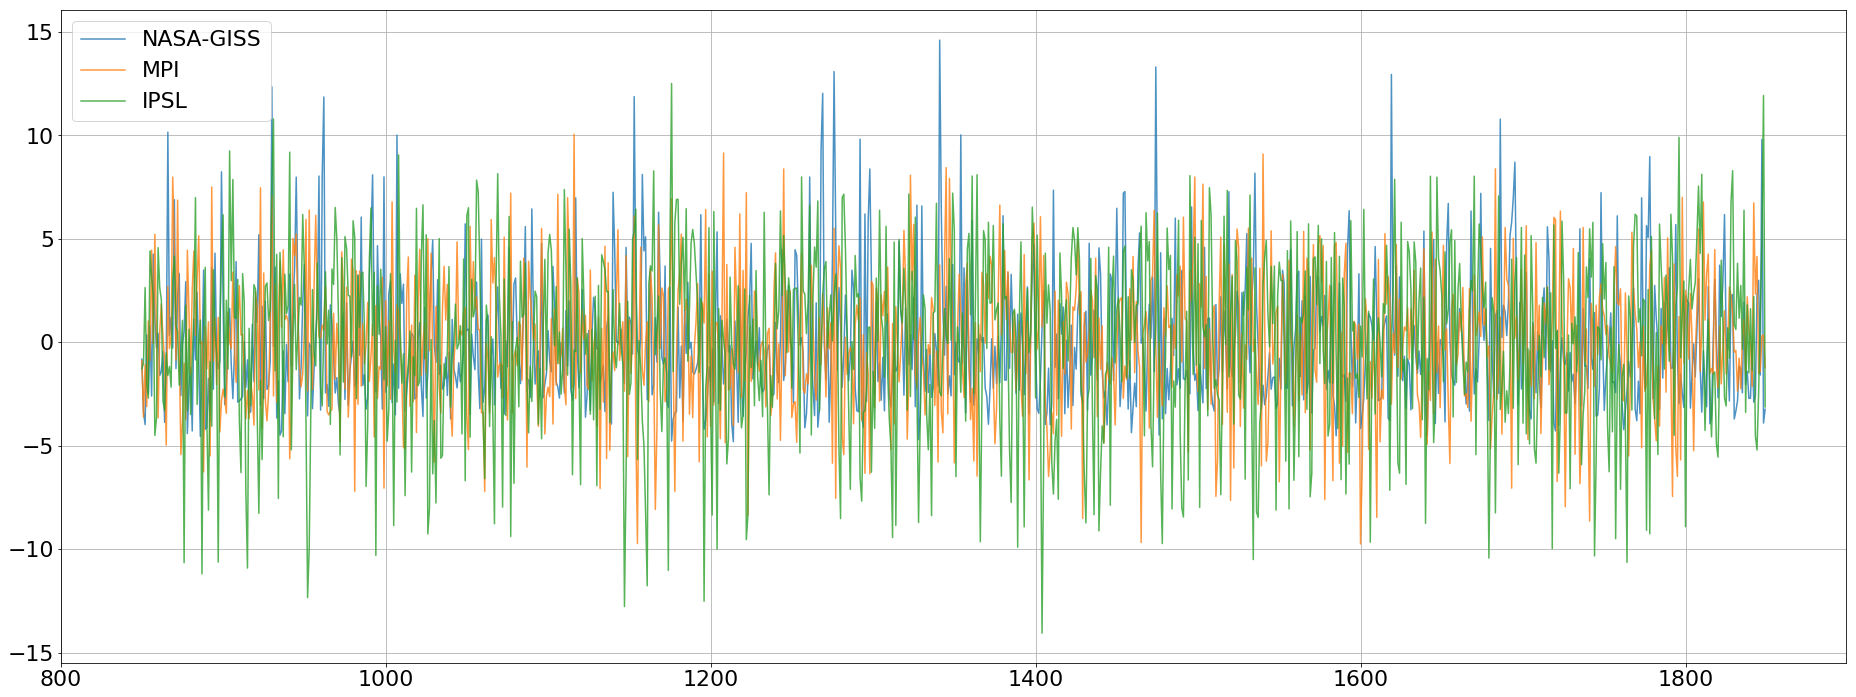

In [11]:
data_ipsl__ = data_ipsl_ann - data_ipsl_ann_ssa[0]
data_giss__ = data_giss_ann - data_giss_ann_ssa[0]
data_mpi__ = data_mpi_ann - data_mpi_ann_ssa[0]
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(32,12))
plt.plot(yy_ann, data_giss__, label='NASA-GISS', alpha=0.8)
plt.plot(yy_ann, data_mpi__, label='MPI', alpha=0.8)
plt.plot(yy_ann, data_ipsl__, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

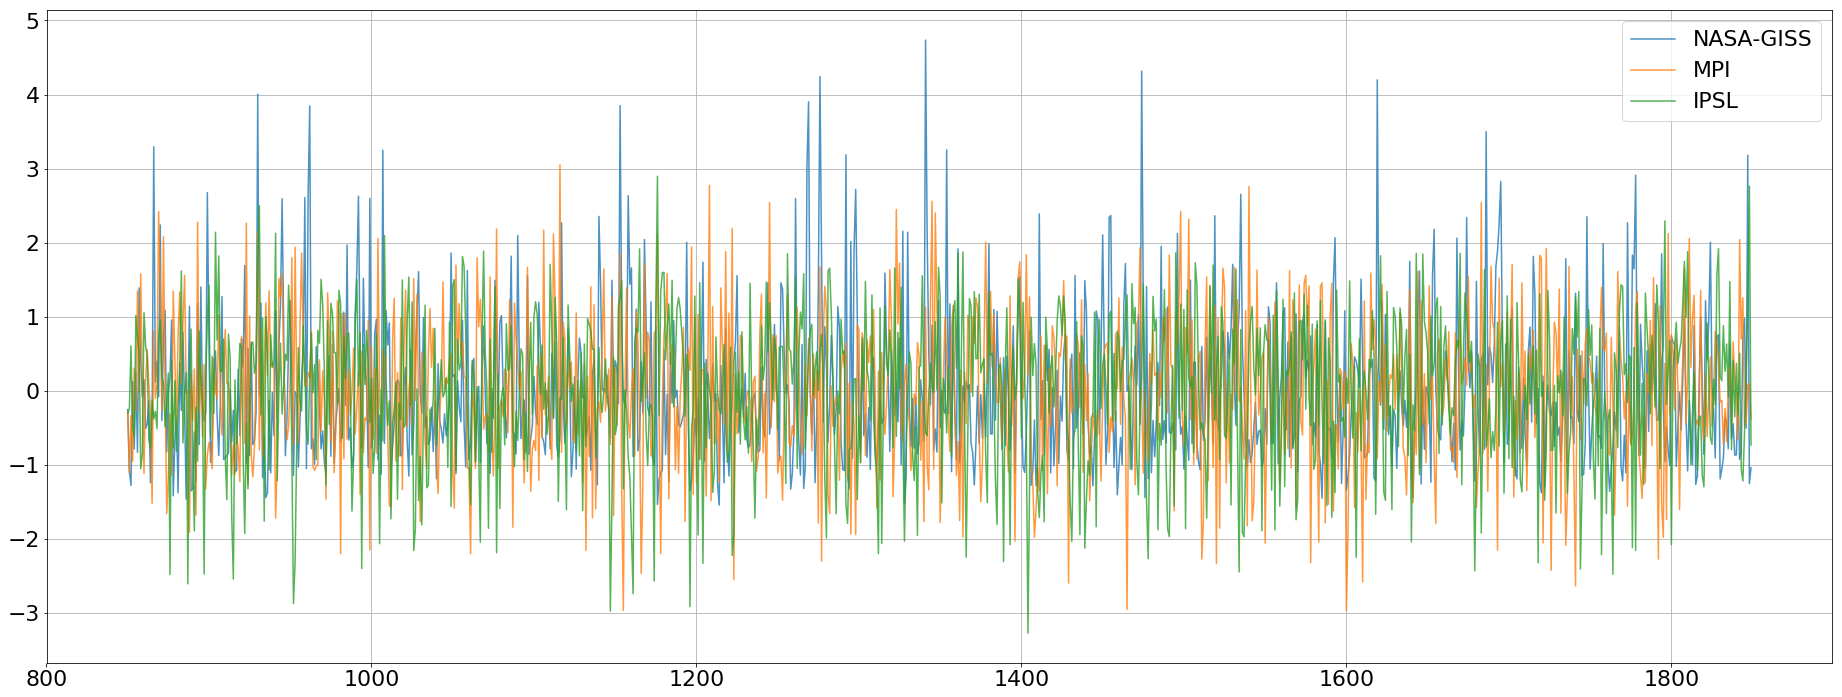

In [12]:
# Standardizing the monthly anomalies obtained from SSA
data_ipsl_norm = (data_ipsl__ - np.mean(data_ipsl__))/np.std(data_ipsl__)
data_giss_norm = (data_giss__ - np.mean(data_giss__))/np.std(data_giss__)
data_mpi_norm = (data_mpi__ - np.mean(data_mpi__))/np.std(data_mpi__)
plt.figure(figsize=(32,12))
plt.plot(yy_ann, data_giss_norm, label='NASA-GISS', alpha=0.8)
plt.plot(yy_ann, data_mpi_norm, label='MPI', alpha=0.8)
plt.plot(yy_ann, data_ipsl_norm, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

In [15]:
event_drought_ipsl = np.zeros((yy_ann.shape[0]))
event_drought_giss = np.zeros((yy_ann.shape[0]))
event_drought_mpi = np.zeros((yy_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_ann.shape[0]))

In [16]:
event_drought_ipsl[data_ipsl_norm<-1.0] = 1.0
event_drought_giss[data_giss_norm<-1.0] = 1.0
event_drought_mpi[data_mpi_norm<-1.0] = 1.0

for i in range(yy_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=3.7:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [17]:
np.savetxt('drought_ipsl.txt', event_drought_ipsl, delimiter=",")
np.savetxt('drought_giss.txt', event_drought_giss, delimiter=",")
np.savetxt('drought_mpi.txt', event_drought_mpi, delimiter=",")
np.savetxt('all_volc_pmip.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_pmip.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_pmip.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_pmip.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_pmip.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_pmip.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_pmip.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_pmip.txt', event_yy_volc_strong_sh, delimiter=",")